<a href="https://colab.research.google.com/github/9M3a1h3d9i9/RL_Bots/blob/main/Comaire_TD_bot(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import time


# Define the Tower Defense Environment


In [11]:
class TowerDefenseEnv:

    def __init__(self, grid_size=(10, 10), max_steps=50):
        self.performance_log = {"TP": 0, "FP": 0, "TN": 0, "FN": 0}
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.grid = np.zeros(self.grid_size)  # 0: Empty, 1: Path, 2: Tower, 3: Enemy, 4: Bullet
        # Define an updated enemies path
        self.grid[2, 0:5] = 1  # Horizontal part of the path
        self.grid[2:7, 4] = 1  # Vertical part of the path
        self.grid[6, 4:9] = 1  # Horizontal part to the right
        self.enemy_position = [2, 0]  # Enemy starts at the beginning of the path
        self.towers = []  # List of tower positions
        self.bullets = []  # Bullets fired by towers
        self.resources = 10  # Starting resources
        self.step_count = 0
        self.total_reward = 0
        return self.grid.copy()

    def step(self, action):
        """Take an action and
         return the
          new state,
           reward,
            and done flag."""
        reward = 0
        done = False

        # Action: Place tower if resources are sufficient
        if action < self.grid_size[0] * self.grid_size[1]:
            x, y = divmod(action, self.grid_size[1])
            if self.grid[x, y] == 0 and self.resources >= 5:
                self.grid[x, y] = 2  # Place a tower
                self.towers.append((x, y))
                self.resources -= 5

        # Move enemy along the path
        if self.grid[tuple(self.enemy_position)] == 3:
            self.grid[tuple(self.enemy_position)] = 1  # Clear previous position

        if self.enemy_position[1] < 4:
            self.enemy_position[1] += 1  # Horizontal path to the right
        elif self.enemy_position[0] < 6:
            self.enemy_position[0] += 1  # Vertical path downward
        elif self.enemy_position[1] < 8:
            self.enemy_position[1] += 1  # Horizontal path to the right
        else:
            done = True  # Enemy reached the end of the path
            reward = -10

        self.grid[tuple(self.enemy_position)] = 3  # Update enemy position

        # Towers shoot bullets
        for tower in self.towers:
            tower_x, tower_y = tower
            if abs(tower_x - self.enemy_position[0]) + abs(tower_y - self.enemy_position[1]) <= 2:
                # If enemy is within range, fire bullet
                reward += 10
                done = True
                self.grid[tuple(self.enemy_position)] = 1  # Enemy eliminated
                self.enemy_position = [-1, -1]  # Remove enemy

        self.step_count += 1
        self.total_reward += reward
        if self.step_count >= self.max_steps:
            done = True

        # Example of logging outcomes
        if reward > 0:  # Reward indicates success
            self.performance_log["TP"] += 1
        elif done and reward < 0:  # Failure at the end
            self.performance_log["FN"] += 1
        else:  # Non-rewarding or wasteful actions
            self.performance_log["FP"] += 1

        return self.grid.copy(), reward, done

    def render(self):
        print("Current Grid State:")
        for row in self.grid:
            print(" ".join(map(str, row.astype(int))))
        print("\n")

# Define the DQN Agent


In [12]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Flatten(input_shape=(self.state_size,)))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            action = random.randrange(self.action_size)
        else:
            q_values = self.model.predict(state, verbose=0)
            action = np.argmax(q_values[0])
        return action

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Train the DQN Agent


In [33]:
def train_tower_defense():
    env = TowerDefenseEnv()
    state_size = env.grid_size[0] * env.grid_size[1]
    action_size = state_size  # Each cell is a potential action
    agent = DQNAgent(state_size, action_size)
    episodes = 100
    batch_size = 32

    # Store cumulative rewards
    cumulative_rewards = []

    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        total_reward = 0
        for time in range(env.max_steps):
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                print(f"Episode {e + 1}/{episodes} ended with Total Reward: {total_reward}")
                break

        cumulative_rewards.append(total_reward)
        agent.replay(batch_size)

    # Plot final cumulative rewards
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_rewards, color='blue', label='Cumulative Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward Per Episode')
    plt.legend()
    plt.grid()
    plt.show()


# Final Integration
After training, call the following to compute and display the results:

Episode 1/100 ended with Total Reward: -10
Episode 2/100 ended with Total Reward: -10
Episode 3/100 ended with Total Reward: -10
Episode 4/100 ended with Total Reward: 10
Episode 5/100 ended with Total Reward: 10
Episode 6/100 ended with Total Reward: 10
Episode 7/100 ended with Total Reward: 10
Episode 8/100 ended with Total Reward: 10
Episode 9/100 ended with Total Reward: -10
Episode 10/100 ended with Total Reward: 10
Episode 11/100 ended with Total Reward: 10
Episode 12/100 ended with Total Reward: -10
Episode 13/100 ended with Total Reward: 10
Episode 14/100 ended with Total Reward: 10
Episode 15/100 ended with Total Reward: 10
Episode 16/100 ended with Total Reward: 10
Episode 17/100 ended with Total Reward: 10
Episode 18/100 ended with Total Reward: 10
Episode 19/100 ended with Total Reward: 10
Episode 20/100 ended with Total Reward: 10
Episode 21/100 ended with Total Reward: 10
Episode 22/100 ended with Total Reward: 10
Episode 23/100 ended with Total Reward: 10
Episode 24/100 

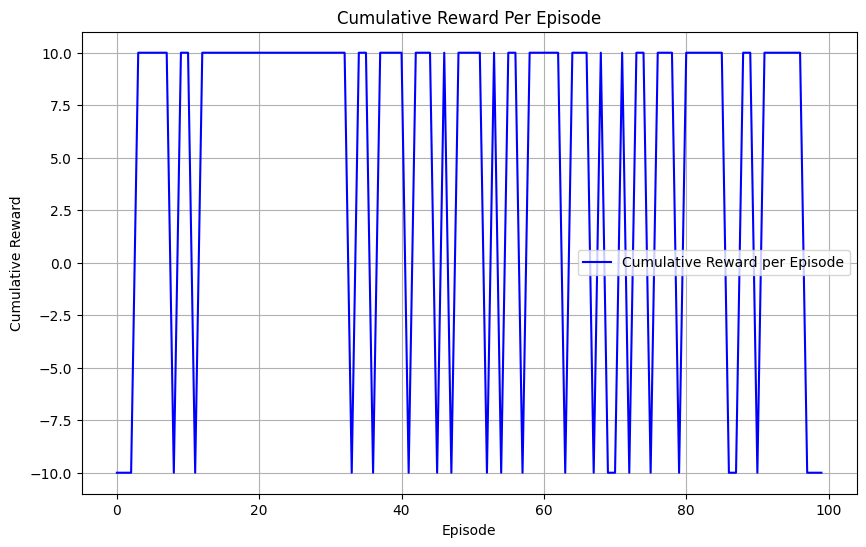

In [34]:
if __name__ == "__main__":
    # env = TowerDefenseEnv()
    train_tower_defense()  # Train the agent
